<a href="https://colab.research.google.com/github/japanipsystem/Test/blob/master/0606_mhawkes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class UniRnd(object):
    def __init__(self, sz=100):
        self.sz = sz
        self.us = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            self.us = np.random.uniform(0, 1, self.sz)
            self.pos = 0
        u = self.us[self.pos]
        self.pos += 1
        return(u)


class Zetad(object): # (5.4)
    def __init__(self, s, ceil, sz=100):
        self.s = s # parameter
        self.ceil = ceil # ceiling
        self.sz = sz
        self.vs = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            vs = np.random.zipf(self.s, self.sz)
            self.vs = np.where(vs < self.ceil, vs, self.ceil)
            self.pos = 0
        v = self.vs[self.pos]
        self.pos += 1
        return(v)

In [ ]:
# Mutual-exciting Hawkes process
class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types

        self.ur = UniRnd()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        self.zetad = Zetad(2.2, 50)
        self.events = []

    def set_seed(self, seed):
        np.random.seed(seed)

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.get()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while psl < l:
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.get()   # get number of shares
            self.tm.append([t, m, sh])

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        """
        Homework (Exercise 4.3): make the matrix lmd_t by (4.7)
        """
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Caes 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while True:
            k += 1
            if k >= steps: break
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        """
        End of homework
        """
        return(np.transpose(lmd_t))

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self): # make the event list self.events according to self.tm.
        evs = [] # list of events
        """
        Homework (Exercese 5.5)
        """
        cur_sh = 0
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            s = tm[2] # event shares
            if m == 0: # market
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'MKT', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1: # limit
                evs.append([t, 'LMT', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            else: # cancel
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'CAN', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
        """
        End of homework
        """
        self.events = evs

    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)

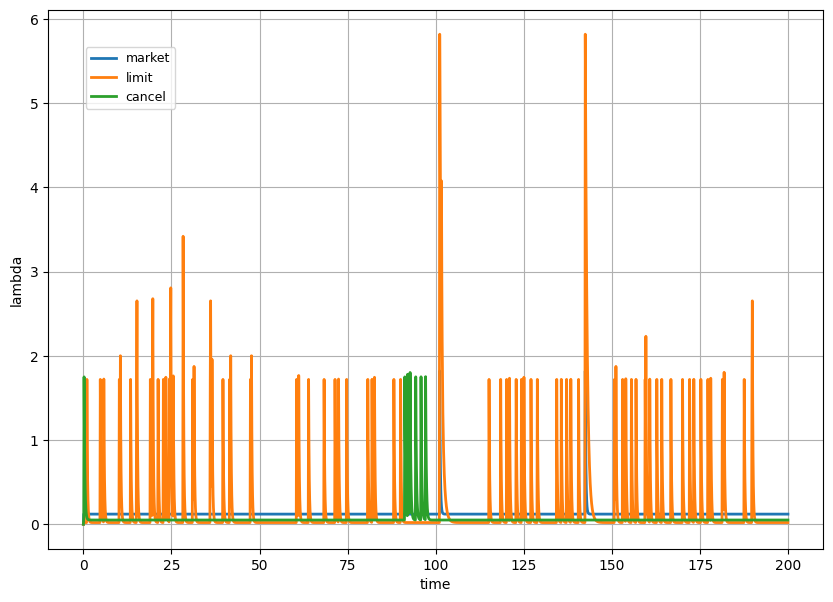

[0.979543423408121, 'LMT', 1]
[0.979543423408121, 'SH', 1]
[4.794917070869318, 'LMT', 1]
[4.794917070869318, 'SH', 2]
[5.7953577402492495, 'LMT', 1]
[5.7953577402492495, 'SH', 3]
[10.138607591879431, 'LMT', 1]
[10.138607591879431, 'SH', 4]
[10.45409385388014, 'LMT', 3]
[10.45409385388014, 'SH', 7]
[13.389402914941911, 'LMT', 1]
[13.389402914941911, 'SH', 8]
[15.076115442091123, 'LMT', 1]
[15.076115442091123, 'SH', 9]
[15.193520541660787, 'LMT', 1]
[15.193520541660787, 'SH', 10]
[18.940612046379275, 'LMT', 2]
[18.940612046379275, 'SH', 12]
[19.512399369374364, 'LMT', 1]
[19.512399369374364, 'SH', 13]
[19.68861029021042, 'LMT', 1]
[19.68861029021042, 'SH', 14]
[21.132686350829232, 'LMT', 1]
[21.132686350829232, 'SH', 15]
[22.6175116479721, 'LMT', 3]
[22.6175116479721, 'SH', 18]
[23.31871317977729, 'LMT', 1]
[23.31871317977729, 'SH', 19]
[24.38483125173939, 'LMT', 1]
[24.38483125173939, 'SH', 20]
[24.60418091904682, 'LMT', 7]
[24.60418091904682, 'SH', 27]
[24.725076732041153, 'LMT', 1]
[2

In [ ]:
if __name__ == '__main__':
    names = ['market', 'limit', 'cancel']
    mu = np.array([0.12, 0.02, 0.05])
    alpha = np.array([[1.7, 5.8, 0], [0, 1.7, 0], [0, 0, 1.7]])
    beta  = np.array([[5.8, 1.8, 0], [0, 6.0, 0], [0, 0, 5.0]])

    T = 200.0
    hp = MHawkes(names, mu, alpha, beta, T)
    #hp.set_seed(1234)
    hp.gen()
    #hp.print_tm()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()